# *In silico* Bayesian optimization with Odyssey

We are now moving away from the local optimizer and use the *real world* Bayesian optimizer in a similar way that you used the SciPy optimizers in `02_Color_Mixing_and_Optimization_InSilico.ipynb`. 

You will be using [**Odyssey**](https://odyssey-51edb0.gitlab.io/), Python-based Bayesian optimization framework developed internally at DTU. You will move on to the PumpBot in the next exercise, so make sure you do proper coding and experiment with parameters in this exercise to make the next one easier. 

You have already gotten a good taste of coding your own Bayesian optimizer in the `04_Bayesian_Optimization_Tutorial.ipynb`, 
but you are generally better off using one of the readily available Bayesian optimizers unless you have something 
very specific in mind. Many of these are built on top of [BoTorch](https://botorch.org/), a very popular Bayesian optimization library in Python.

Please take some time to read the [Structure of Odyssey](https://odyssey-51edb0.gitlab.io/getting-started/structure/) to have an overview its design.

Let's start by importing `Odyssey` and some additional packages.

In [1]:
# Odyssey 
from odyssey.mission import Mission # Mission
from odyssey.objective import Objective # Objective
from odyssey.navigators import SingleGP_Navigator # Navigator
from odyssey.navigators.sampler_navigators import Sobol_Navigator, Grid_Navigator # Sampler
from odyssey.navigators import ExpectedImprovement, ProbabilityOfImprovement, UpperConfidenceBound, LogExpectedImprovement, LogProbabilityOfImprovement # Acquisition functions

# Other Packages
import torch
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
from IPython import display
from warnings import catch_warnings, simplefilter

/Users/achtu/Library/Caches/pypoetry/virtualenvs/ai-orchestrated-sdl-Vzjo9xxG-py3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


You can see that several classes are imported, including `Mission`, `Objective`, `SingleGP_Navigator`, `Sobol_Navigator`, `Grid_Navigator`, and the acquisition functions `ExpectedImprovement`, `LogEI`, `ProbabilityOfImprovement`, `UpperConfidenceBound`, `LogExpectedImprovement`, and `LogProbabilityOfImprovement`. You should read more about these here:

- [Mission](https://odyssey-51edb0.gitlab.io/api_reference/mission/)
- [Objective](https://odyssey-51edb0.gitlab.io/api_reference/objective/#objective)
- Single Objective Navigator:
    - [SingleGP_Navigator](https://odyssey-51edb0.gitlab.io/api_reference/navigators/#odyssey.navigators.SingleGP_Navigator)
- Sampler Navigator:
    - [Sobol Sampler Navigator](https://odyssey-51edb0.gitlab.io/api_reference/navigators/#odyssey.navigators.sampler_navigators.Sobol_Navigator)
- [Acquisition Functions](https://odyssey-51edb0.gitlab.io/api_reference/acquisition_functions/)

## Exercise 5.1: Optimization of Single-Input-Single-Output (SISO) function

Let's start with a (very) simple example of finding the global minimum of the function below for $x \in [-5, 5]$.

In [2]:
def simple_function(x):
    val = x ** 4 - 10 * x**2 + 5 * x
    return val/100

Let's visualize the `simple_function` to see where the minimum values are.

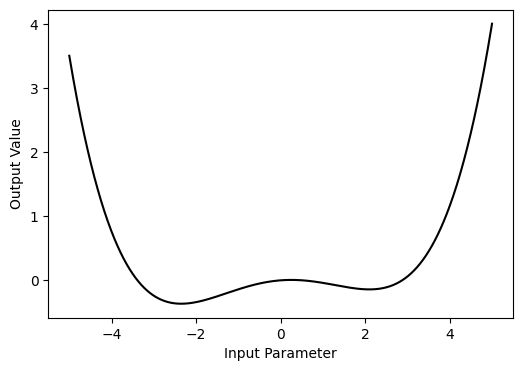

In [3]:
test_X = torch.linspace(-5, 5, 1000)
test_Y = simple_function(test_X)

plt.figure(figsize=(6, 4))
plt.plot(test_X, test_Y, color='black')
plt.xlabel('Input Parameter')
plt.ylabel('Output Value')
plt.show()

You can see that there are two local minima: $x \approx -2.35$ and $x \approx +2.1$. The first one is the global minimum. 

We now proceed to find the global minimum using Odyssey. We start our "mission" (also often called campaign) using Odyssey's `Mission` class, which takes several attributes.  

```python
mission = Misson(name='Name of your mission',
                 funcs=[],
                 maneuvers=goals,
                 envelope=param_space)
```

The `funcs` is a list of objective functions, while `manuevers` is a list of goals, which can be either ascend (i.e., finding global maximum) or descend (i.e., finding global minimum). We start by creating an objective function for Odyssey using our `simple_function`.

In [4]:
objective = Objective(func=simple_function)

Next up, we initialize our mission. Note that `func` and `maneuvers` are list of length one for a single-objective optimization. The lengths of these attributes are longer for the multi-objective cases. 

In [5]:
mission = Mission(name="Minimizing a simple function",
                  funcs=[objective],
                  maneuvers=['descend'],
                  envelope=[(-5.0, 5.0)])

We have now defined our mission by specifying our objective function, whether we would like to find a maximum/minimum, and the boundaries of the domain we would like to explore. The next step is to specify how we would like to navigate through our search space, and we achieve this using `Navigator`. 

We use `SingleGP_Navigator` for single-objective Bayesian optimization, which employs a single Gaussian Process (GP) model to approximate the objective function and guide the search for the optimal solution using an acquisition function. The first step of the optimization sequence to explore a fixed set of initial data points before using the acquisition function. Let's explore 3 initial points, which is selected in a uniform fashion by dividing our search space into grids. Once the initial points are explored, we will continue the optimization by using `ExpectedImprovement` as an acquisition function. 

In [6]:
num_init_points = 3
navigator = SingleGP_Navigator(mission=mission,
                               num_init_design=num_init_points,
                               input_scaling=False,
                               data_standardization=False,
                               init_method=Grid_Navigator(mission=mission, subdivisions=num_init_points),
                               acq_function_type=ExpectedImprovement,
                               acq_function_params={'best_f': 0.0}
)

tensor([[5.]])
tensor([[-5.]])
tensor([[0.]])
Succesfully appended {'param_1': [5.0, -5.0, 0.0], 'objective_1': [4.0, 3.5, 0.0], 'creation_timestamp': '19-08-25 16:52:14'} to missionlogs/Minimizing a simple function-190825_165214.csv


/Users/achtu/Library/Caches/pypoetry/virtualenvs/ai-orchestrated-sdl-Vzjo9xxG-py3.13/lib/python3.13/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Although it was not so obvious, initiating the navigator above has already selected 3 points and evaluated the objective function. You can see that by plotting the objective function and the observed points. Since we can use these functionalities multiple times, let's make them into functions.

In [7]:
def calculate_posterior():
    model = navigator.model
    pred_mean = -model.posterior(test_X).mean.detach().squeeze()
    pred_std = torch.sqrt(model.posterior(test_X).variance).detach().squeeze()
    return (pred_mean, pred_std)

In [8]:
def plot_progres():
    fig, ax = plt.subplots(figsize=(10, 6))
    pred_mean, pred_std = calculate_posterior()
    # Real function
    ax.plot(test_X, test_Y, color='red', label='Real Function')
    # Measurements
    ax.scatter(mission.display_X, mission.display_Y, color = 'k', marker = '.', label='Measurements')
    # Posterior model and uncertainty
    ax.plot(test_X.squeeze(), pred_mean, color = 'g', linestyle = 'dashed', label = 'Posterior Model')
    ax.fill_between(test_X.squeeze(), pred_mean - 2*pred_std, pred_mean + 2*pred_std, color  ='g', alpha = 0.3, label = 'Posterior Uncertainty')

    ax.set_xlabel('Input Parameter')
    ax.set_ylabel('Output Value')
    ax.title.set_text(f'Iteration: {len(mission.train_X) - num_init_points}, new x = {trajectory.item():.3f}, y = {observation.item():.3f}')
    ax.legend()

    plt.show()

Succesfully appended {'param_1': [-0.260421220848195], 'objective_1': [-0.019756987813689578], 'creation_timestamp': '19-08-25 16:52:15'} to missionlogs/Minimizing a simple function-190825_165214.csv


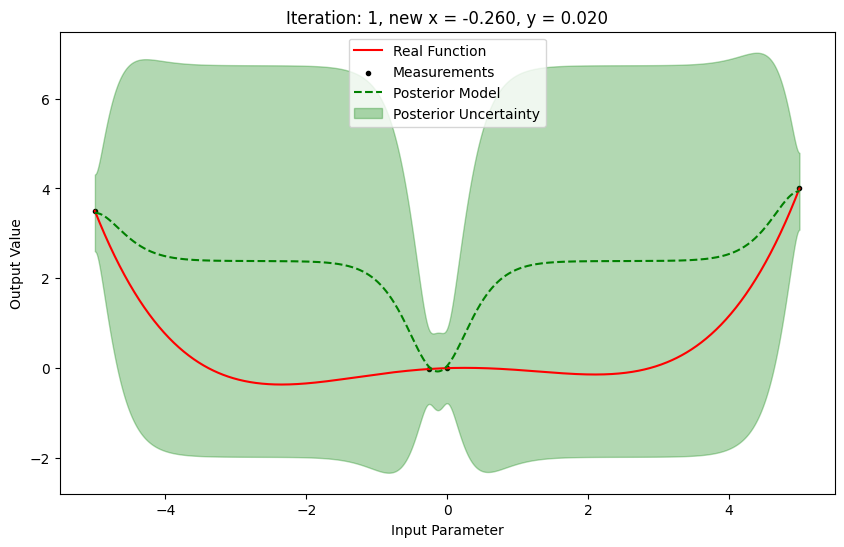

Succesfully appended {'param_1': [-0.6605976688449734], 'objective_1': [-0.07476445541287279], 'creation_timestamp': '19-08-25 16:52:16'} to missionlogs/Minimizing a simple function-190825_165214.csv


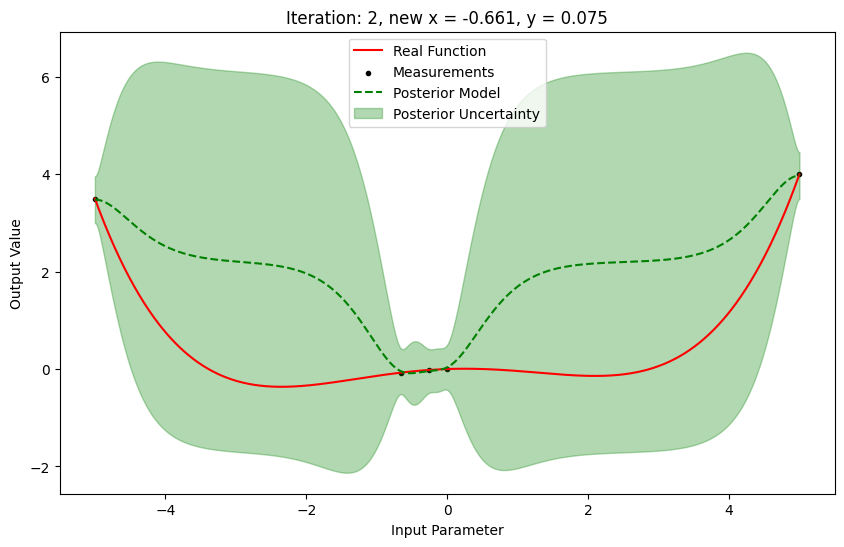

Succesfully appended {'param_1': [-1.194476892338543], 'objective_1': [-0.18204447892168052], 'creation_timestamp': '19-08-25 16:52:17'} to missionlogs/Minimizing a simple function-190825_165214.csv


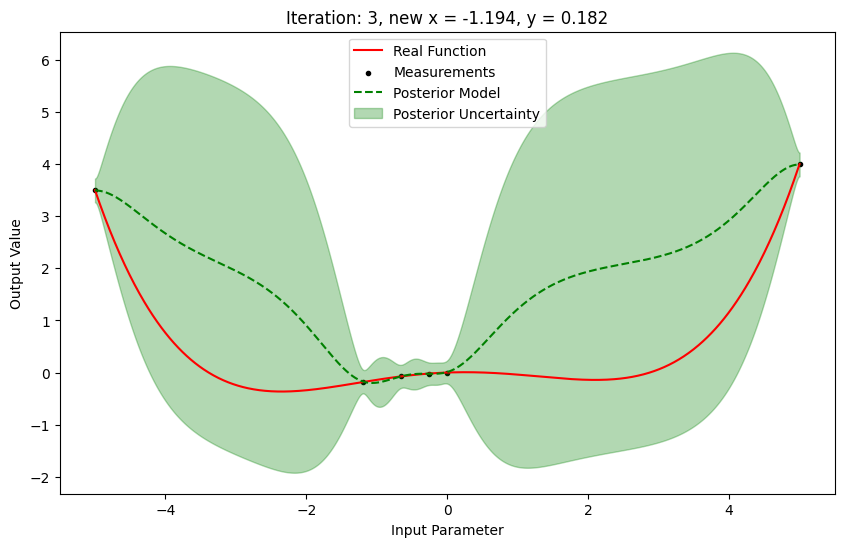

Succesfully appended {'param_1': [-1.8864442480655177], 'objective_1': [-0.3235479455153208], 'creation_timestamp': '19-08-25 16:52:18'} to missionlogs/Minimizing a simple function-190825_165214.csv


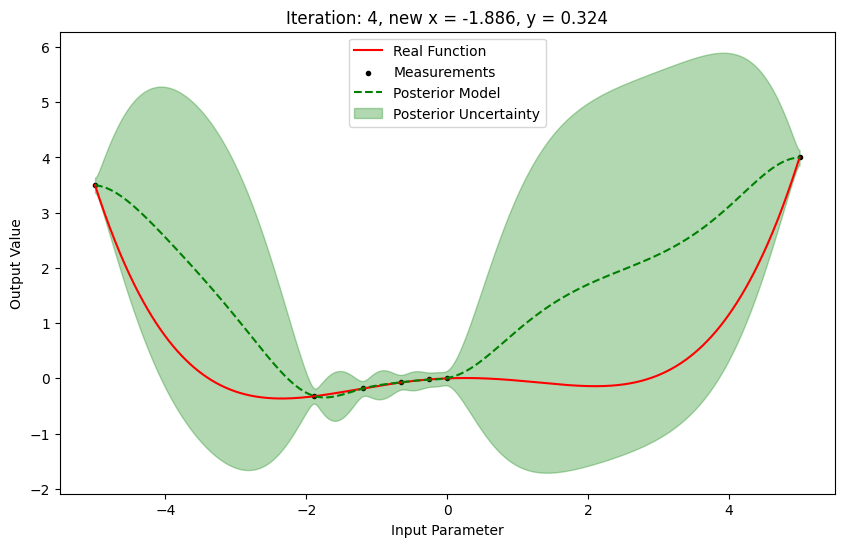

Succesfully appended {'param_1': [-2.577173862853255], 'objective_1': [-0.3519027959165893], 'creation_timestamp': '19-08-25 16:52:18'} to missionlogs/Minimizing a simple function-190825_165214.csv


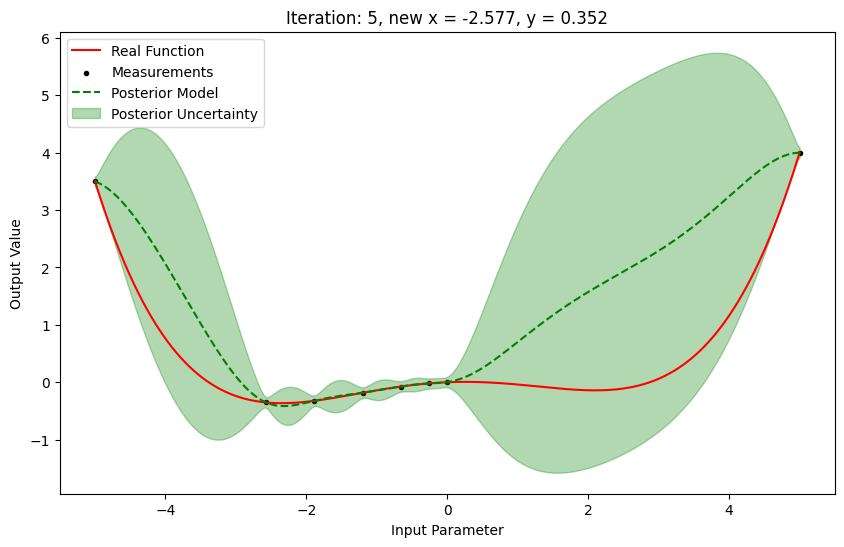

Succesfully appended {'param_1': [-2.2854111509481374], 'objective_1': [-0.36377280302418236], 'creation_timestamp': '19-08-25 16:52:19'} to missionlogs/Minimizing a simple function-190825_165214.csv


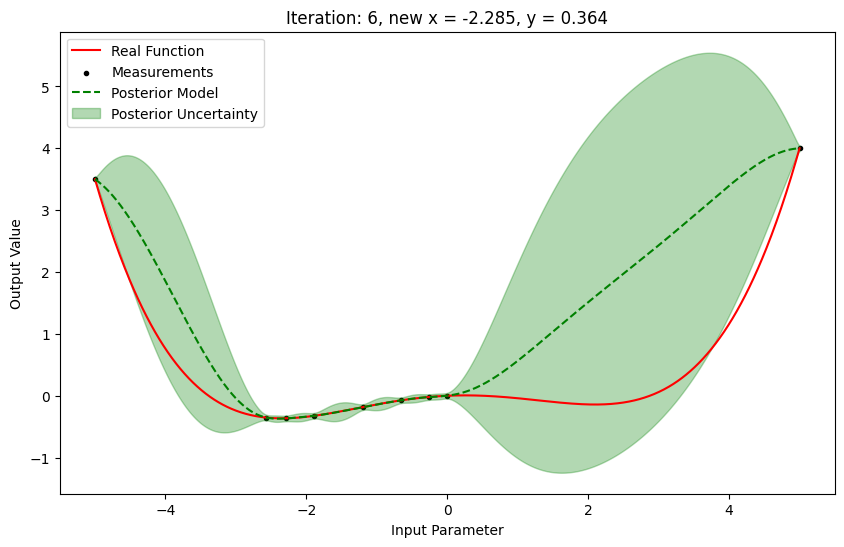

Succesfully appended {'param_1': [1.4792875717697744], 'objective_1': [-0.09697858689288479], 'creation_timestamp': '19-08-25 16:52:19'} to missionlogs/Minimizing a simple function-190825_165214.csv


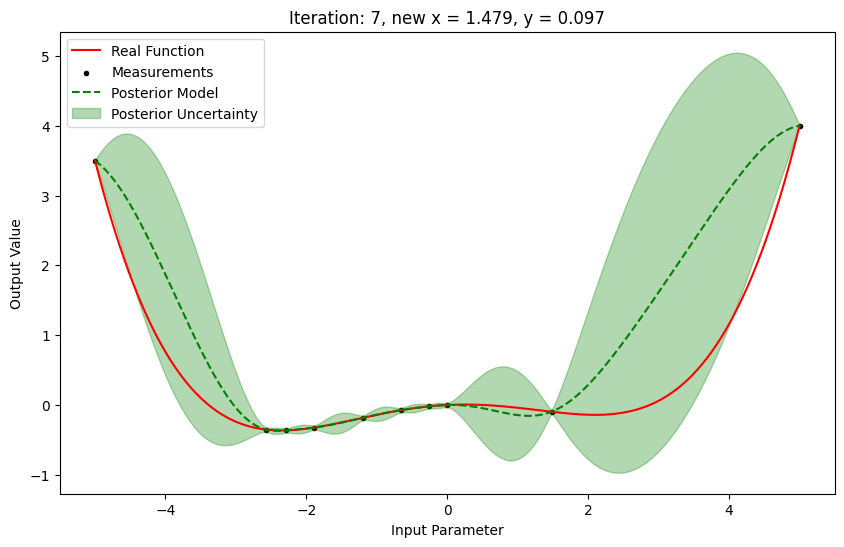

Succesfully appended {'param_1': [0.9238672591561727], 'objective_1': [-0.03187456152376224], 'creation_timestamp': '19-08-25 16:52:20'} to missionlogs/Minimizing a simple function-190825_165214.csv


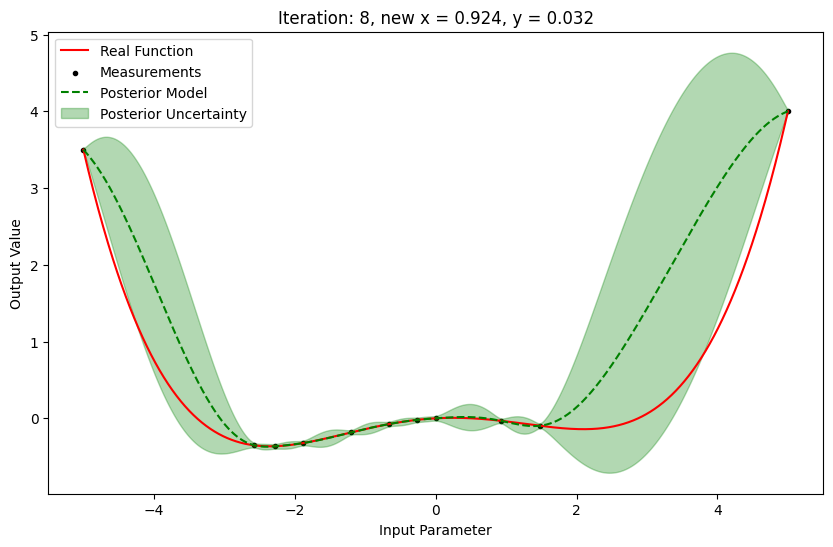

Succesfully appended {'param_1': [2.435384615626198], 'objective_1': [-0.119561330153551], 'creation_timestamp': '19-08-25 16:52:20'} to missionlogs/Minimizing a simple function-190825_165214.csv


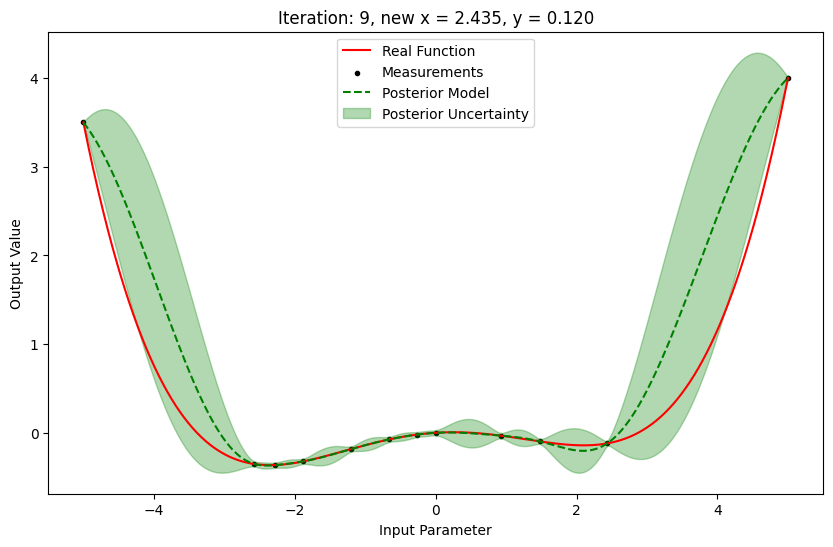

Succesfully appended {'param_1': [-2.4044810139002433], 'objective_1': [-0.364116175757422], 'creation_timestamp': '19-08-25 16:52:27'} to missionlogs/Minimizing a simple function-190825_165214.csv


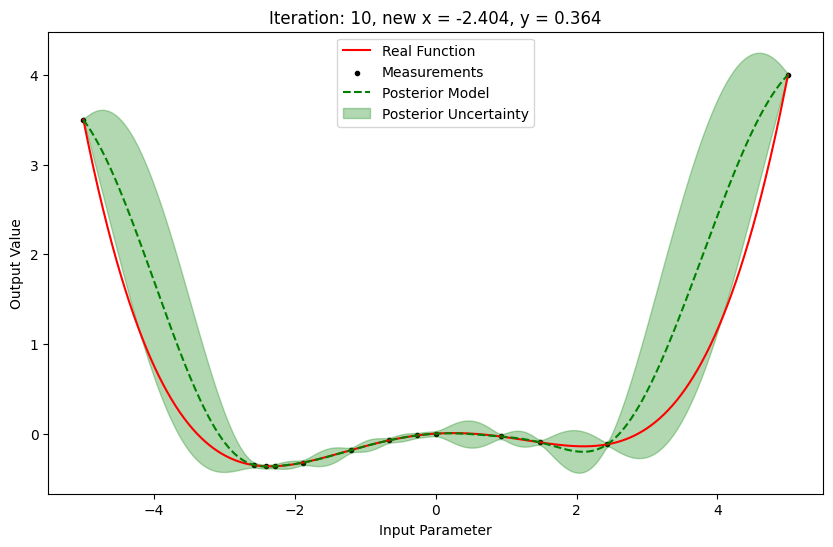

In [ ]:
num_iter = 10

from warnings import catch_warnings
from warnings import simplefilter

while len(mission.train_X) - num_init_points < num_iter:
    with catch_warnings() as w:
        simplefilter('ignore')
        trajectory = navigator.trajectory()
        observation = navigator.probe(trajectory, init = False)
        navigator.relay(trajectory, observation)
        navigator.upgrade()
        
        display.clear_output(wait=True) # This will help you remove figures as you go
        plot_progres()
        input('Press Enter to proceed.')

You are **strongly** encouraged to experiment with different acquisition functions and parameters, including the `num_iter` value to see how the optimization progresses if you let it run longer. Once you are done with the optimization, you can run the cell below to see what is the best observed point is. 

In [10]:
best_idx = mission.display_Y.argmin().item()
best_input = mission.display_X[best_idx].item()
best_output = mission.display_Y[best_idx].item()

print(f'Best Input: {best_input}')
print(f'Best Output: {best_output}')

Best Input: -2.4044810139002433
Best Output: -0.364116175757422


## Exercise 5.2: Single-Input-Single-Output (SISO) function with noise

You have completed the most basic optimization. Let's make this a bit more challenging by adding some noise. Please read through the example from the Odyssey documentation [here](https://odyssey-51edb0.gitlab.io/examples/single-objective-optimization/) and run it yourself in the cells below. 

Feel free to add more cells as you need.

In [11]:
# place for your code

In [12]:
# place for your code

In [13]:
# place for your code

In [14]:
# place for your code

## Exercise 5.3: Moving on to the color mixing

You have learned what you need to know about Odyssey! It is time to get back to the color mixing. 

As usual, we use `SilicoPumpController` of pump_controller module to simulate the color mixing. In case you have forgotten, you can read more about the different classes and methods in the pump_controller module [here](https://www.student.dtu.dk/~s193903/47332/).

Reusing your code from the first *in silico* exercise, figure out how to mix the taget color below using Odyssey.

You will use this code on the pumpbot tomorrow, so be thorough and make sure to include breakpoints during the function calls. Plotting progress using `visualize_candidates()` function will be very helpful in understanding how the optimization is progressing and whether or no you are satisfied with the results. 

In [15]:
# Pump Controller
from pump_controller import SilicoPumpController, visualize_rgb, visualize_candidates, read_logfile

In [16]:
target_color = [164., 176., 84.]

In [17]:
# Let's have some noise to keep it real.
silicobot = SilicoPumpController(noise_std = 3)

In [18]:
# function for getting the color difference
def color_difference(mixed_color, target_color):
    # your code goes here

_IncompleteInputError: incomplete input (845874340.py, line 3)

In [ ]:
# This is going to be your objective function
def find_score_from_color(mixture):
    # take the mixture [R, G, B, Y] and return the score. 
    


In [ ]:
# place for your code

In [ ]:
# place for your code

In [ ]:
# place for your code

In [ ]:
# place for your code.  Add more as needed.

When you are done, find the best observed point and plot its composition and color, taget color, and score using `visualize_rgb()` function.

In [ ]:
# place for your code.

## Exercise 5.4: Re-using the old data

You may have noticed that the optimizations we have performed so far (both local and Bayesian optimizers) did not make use of previously collected data. Whenever you start a new optimization (i.e., initializing a mission or loading a local optimizer), you essentially start from scratch. Clearly, this is not ideal, especially if you have already collected some data from previous experiments.

Odyssey has a feature of loading previously generated data using `DataLoader`. You can find its documentation and example [here](https://odyssey-51edb0.gitlab.io/api_reference/navigators/#dataloader).

You start by loading the `DataLoader` as shown below.

In [ ]:
from odyssey.navigators import DataLoader

Using the first simple function case as an example, the cell below will load the data from the previously generated CSV files, which is then passed to the navigator as an `init_method`. Note that the warning message will be there if your `num_init_design` value is less than what was loaded from the `DataLoader`. The example below will only load the first 3 cases. Make changes to its value, depending on how many data points you would like to load.

In [ ]:
# change the names of the files to match what you like to load
datafiles = ['missionlogs/Minimizing a simple function-110624_130807.csv', 
             'missionlogs/Minimizing a simple function-110624_132237.csv']

objective = Objective(func=simple_function)

mission = Mission(name="Minimizing a simple function",
                  funcs=[objective],
                  maneuvers=['descend'],
                  envelope=[(-5.0, 5.0)])

num_init_points = 3
navigator = SingleGP_Navigator(mission=mission,
                               num_init_design=num_init_points,
                               input_scaling=False,
                               data_standardization=False,
                               init_method=DataLoader(mission = mission, datafiles = datafiles),
                               acq_function_type=ExpectedImprovement,
                               acq_function_params={'best_f': 0.0}
)

There you go! Now you know how to load data from the previous work.

This concludes todays notebook.